
# 🩸 Blood Donation — EDA, Forecasting, and Availability Prediction

**Goal:** End‑to‑end & reproducible analysis:
1) Explore the data and clean PII
2) Understand donor & blood group distributions
3) Analyze monthly donor sign‑ups and forecast next 12 months
4) Predict donor **availability (Yes/No)** from profile features

# 1) Setup & Imports

In [35]:
import os, glob, json, math, warnings, itertools, textwrap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Matplotlib fig
plt.rcParams['figure.figsize'] = (10, 5)

# 2) Load Data 

In [36]:
df = pd.read_csv("blood_donor_dataset.csv")

df.head()

,donor_id,name,email,password,contact_number,city,blood_group,availability,months_since_first_donation,number_of_donation,pints_donated,created_at
0,1b8b4c828a,Norma Fisher,ysullivan@yahoo.com,P5hX6Syg*A,+61 461706749,Hobart,A+,No,65,31,62,2017-03-17
1,a6a3f7fe55,Eugene Bowman,hramos@brown-sellers.com,b6Wq6Cqz@5,+61 450709944,Darwin,AB-,Yes,64,8,16,2016-11-11
2,cee6478144,Sheri Bolton DDS,jasmine85@hotmail.com,$9RB51m#s7,+61 428756361,Melbourne,AB+,Yes,39,6,6,2022-02-25
3,5986bc55f9,Kelly Boyd,pattylawrence@riley-hayes.com,@5Tdg(4kCm,+61 454318320,Darwin,A-,No,55,20,20,2025-04-04
4,93246afe6c,Taylor Guzman,martinezjacob@wilson.com,x!)9Ag@J*7,+61 484158472,Darwin,O-,No,7,35,35,2022-11-30



## 3) Data Overview & Privacy

We remove personally identifiable information (PII) before any analysis or sharing. We keep only analytical features.


In [37]:
# Columns likely to be PII
pii_cols = ['name','email','password','contact_number']
cols_to_keep = [c for c in df.columns if c not in pii_cols]
df = df[cols_to_keep].copy()

# Parse dates if present
date_cols = []
for c in df.columns:
    if 'date' in c.lower() or c.lower().endswith('_at'):
        date_cols.append(c)
for c in date_cols:
    try:
        df[c] = pd.to_datetime(df[c], errors='coerce')
    except Exception:
        pass

# Basic structure
display(df.head())
display(df.dtypes.to_frame('dtype').T)
print('Rows:', len(df))
print('Missing by column:\n', df.isna().sum())


,donor_id,city,blood_group,availability,months_since_first_donation,number_of_donation,pints_donated,created_at
0,1b8b4c828a,Hobart,A+,No,65,31,62,2017-03-17
1,a6a3f7fe55,Darwin,AB-,Yes,64,8,16,2016-11-11
2,cee6478144,Melbourne,AB+,Yes,39,6,6,2022-02-25
3,5986bc55f9,Darwin,A-,No,55,20,20,2025-04-04
4,93246afe6c,Darwin,O-,No,7,35,35,2022-11-30


,donor_id,city,blood_group,availability,months_since_first_donation,number_of_donation,pints_donated,created_at
dtype,object,object,object,object,int64,int64,int64,datetime64[ns]


Rows: 10000
Missing by column:
 donor_id                       0
city                           0
blood_group                    0
availability                   0
months_since_first_donation    0
number_of_donation             0
pints_donated                  0
created_at                     0
dtype: int64



## 4) Basic Cleaning & Feature Engineering
- Drop exact duplicate rows (if any)
- Ensure `donor_id` uniqueness
- Create time-based fields from `created_at` (Year/Month) for time-series
- Keep numeric features as integers where applicable


In [38]:
# Drop duplicate rows
before = len(df)
df = df.drop_duplicates().copy()
print(f'Dropped {before - len(df)} duplicate rows')

# Donor ID uniqueness check (if present)
if 'donor_id' in df.columns:
    nunique = df['donor_id'].nunique()
    print('Unique donor_id:', nunique, ' / rows:', len(df))

# Derive time features
if 'created_at' in df.columns and pd.api.types.is_datetime64_any_dtype(df['created_at']):
    df['year'] = df['created_at'].dt.year
    df['month'] = df['created_at'].dt.month
    df['year_month'] = df['created_at'].dt.to_period('M').astype(str)

# Ensure numeric types are correct
for num_col in ['months_since_first_donation','number_of_donation','pints_donated']:
    if num_col in df.columns:
        df[num_col] = pd.to_numeric(df[num_col], errors='coerce').astype('Int64')

# Save a cleaned, PII-stripped copy (optional)
clean_path = 'blood_donor_clean.csv'
df.to_csv(clean_path, index=False)
print('Saved cleaned dataset to', clean_path)

Dropped 0 duplicate rows
Unique donor_id: 10000  / rows: 10000
Saved cleaned dataset to blood_donor_clean.csv



## 5) Exploratory Data Analysis (EDA)
We look at distributions and simple relationships.


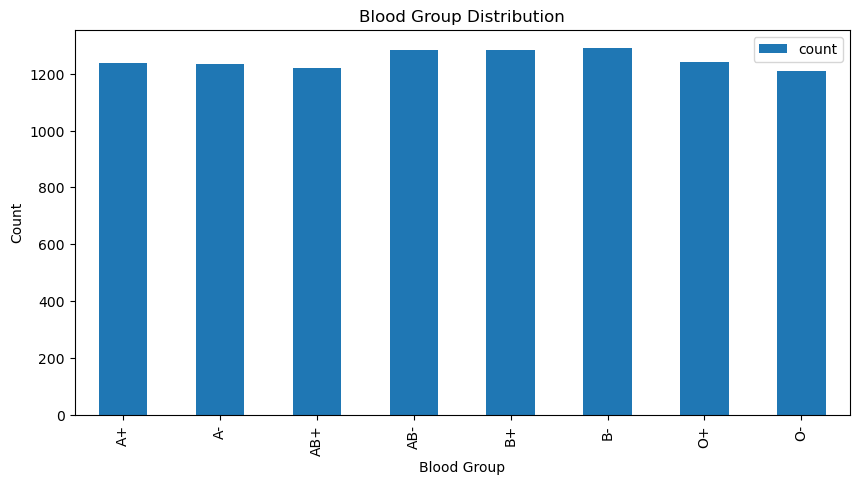

In [39]:
# Blood group distribution by Bar plot -
if 'blood_group' in df.columns:
    bg_counts = df['blood_group'].value_counts().sort_index()
    ax = bg_counts.plot(kind='bar')
    
    ax.set_title('Blood Group Distribution')
    ax.set_xlabel('Blood Group')
    ax.set_ylabel('Count')
    ax.legend()
    plt.show()

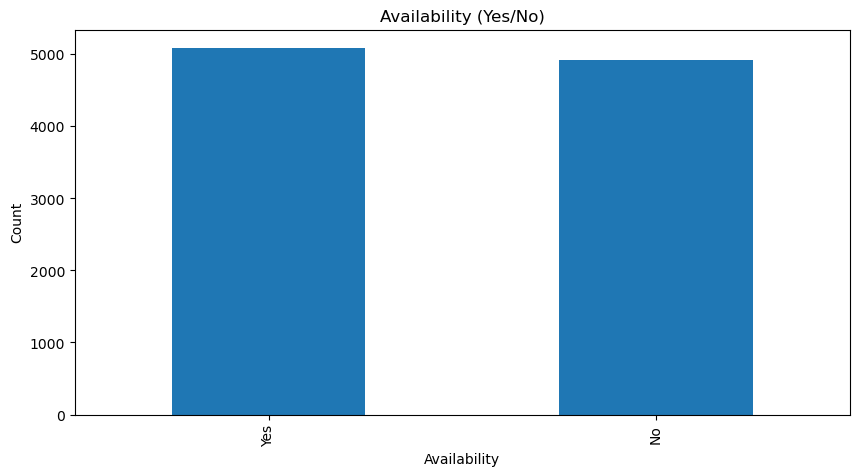

In [40]:
# Availability distribution -
if 'availability' in df.columns:
    avail_counts = df['availability'].value_counts()
    ax = avail_counts.plot(kind='bar')
    # ax = avail_counts.plot(kind='line') No use
    
    ax.set_title('Availability (Yes/No)')
    ax.set_xlabel('Availability')
    ax.set_ylabel('Count')
    plt.show()

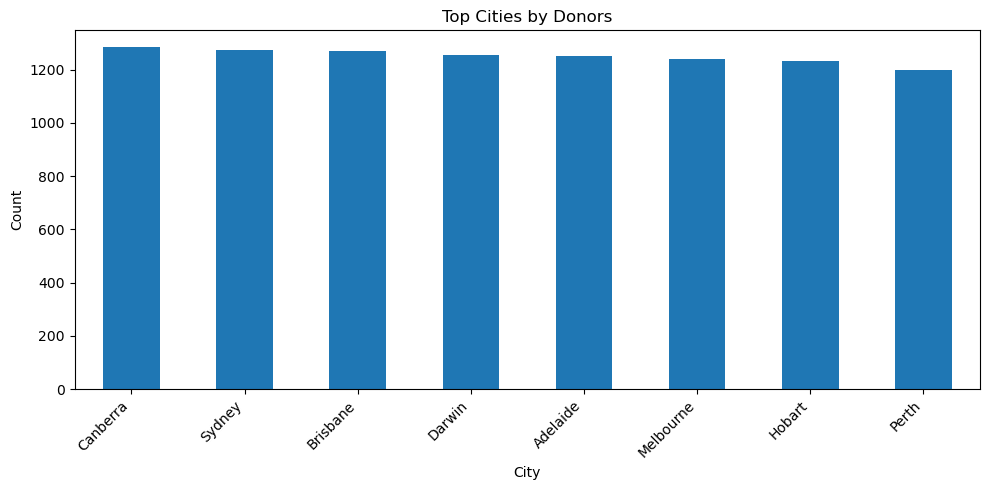

In [41]:
# Top cities who have much Donors
if 'city' in df.columns:
    city_counts = df['city'].value_counts().head(15)
    ax = city_counts.plot(kind='bar')
    
    ax.set_title('Top Cities by Donors')
    ax.set_xlabel('City')
    ax.set_ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

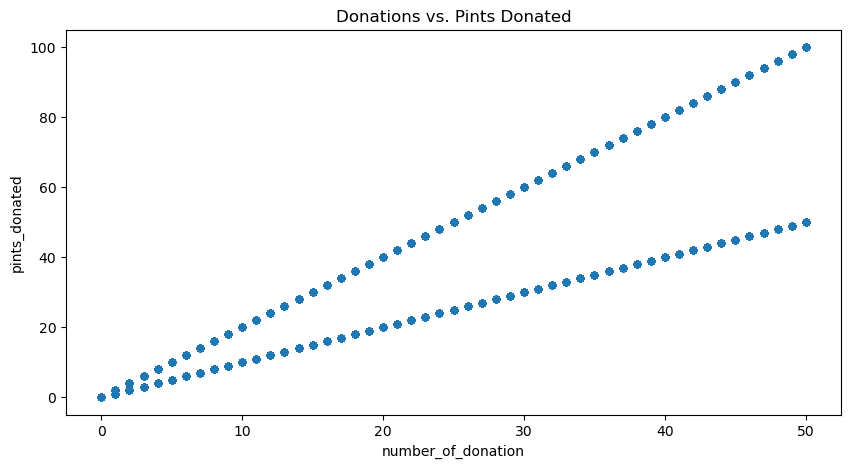

In [42]:
# Relationship: number_of_donation vs. pints_donated
if all(c in df.columns for c in ['number_of_donation','pints_donated']):
    ax = df.plot(kind='scatter', x='number_of_donation', y='pints_donated', alpha=0.5) # x & y both are inputs from c from col.
    
    ax.set_title('Donations vs. Pints Donated')
    plt.show()


## 6) Time Series — Monthly New Donors (by `created_at`)
We aggregate counts per month to analyze trends and forecast the next 12 months.


created_at
2015-07-01     86
2015-08-01    102
2015-09-01     70
2015-10-01     94
2015-11-01     77
Freq: MS, Name: new_donors, dtype: int64

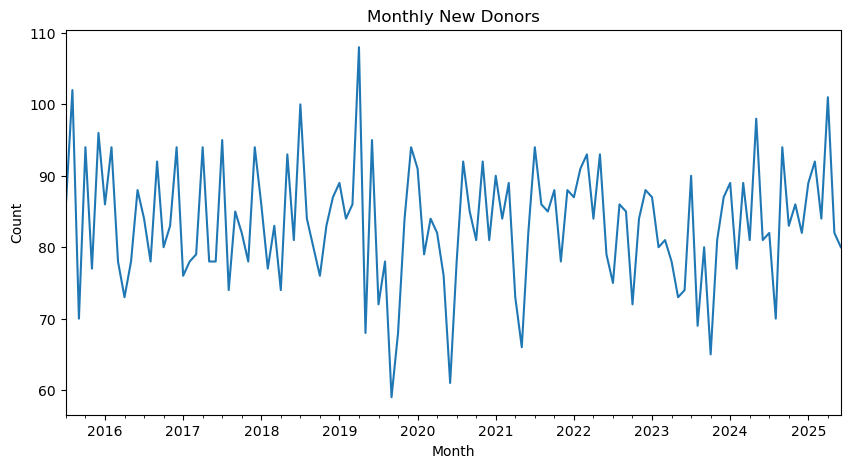

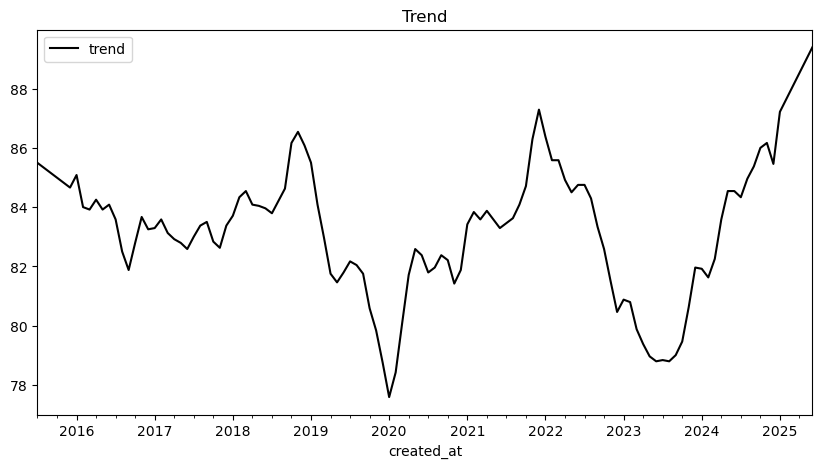

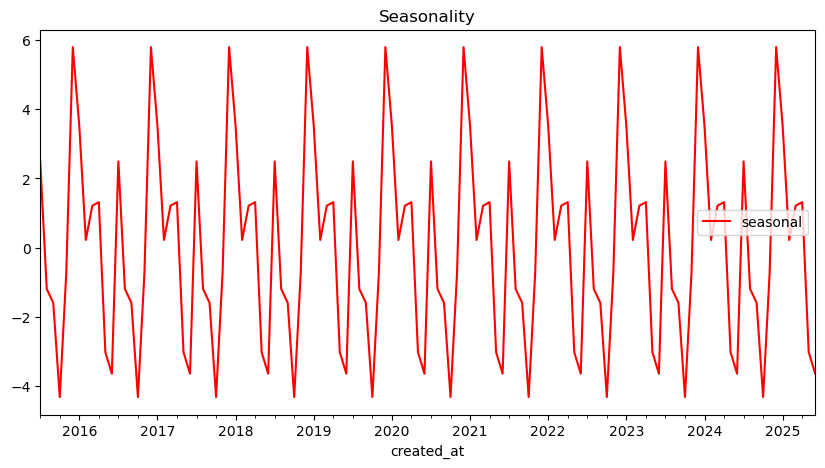

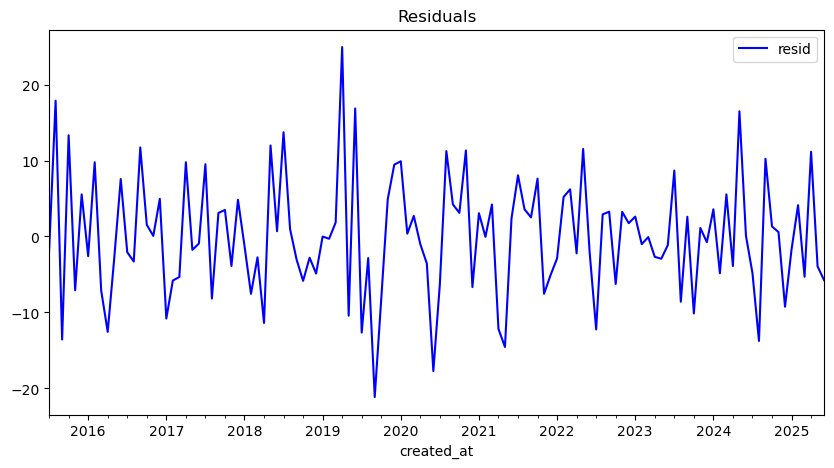

In [43]:

ts = None
if 'created_at' in df.columns and pd.api.types.is_datetime64_any_dtype(df['created_at']):
    monthly = df.set_index('created_at').resample('MS')['donor_id' if 'donor_id' in df.columns else df.columns[0]].count()
    monthly.name = 'new_donors'
    ts = monthly
    display(monthly.head())

    ax = monthly.plot()
    ax.set_title('Monthly New Donors')
    ax.set_xlabel('Month')
    ax.set_ylabel('Count')
    plt.show()

    # Seasonal decomposition
    if len(monthly) >= 36:
        result = seasonal_decompose(monthly, period=12, model='additive', extrapolate_trend='freq')
        
        result.trend.plot(title='Trend', color='black')
        plt.legend()
        plt.show()
        
        result.seasonal.plot(title='Seasonality', color='red')
        plt.legend()
        plt.show()
        
        result.resid.plot(title='Residuals', color='blue')
        plt.legend()
        plt.show()


## 7) Forecasting Next 12 Months (Exponential Smoothing)
We hold out the last 12 months as test, fit an additive trend + seasonality model, evaluate, then refit on full data and forecast 12 months ahead.


{'RMSE': 9.11, 'MAPE_%': 8.2}


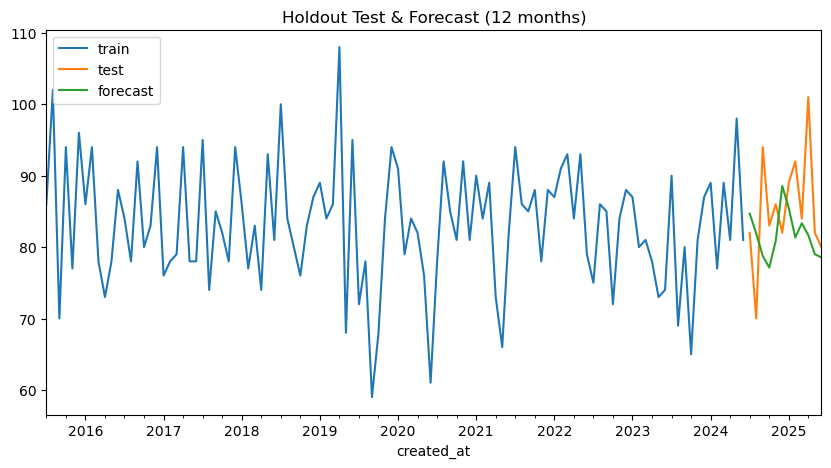

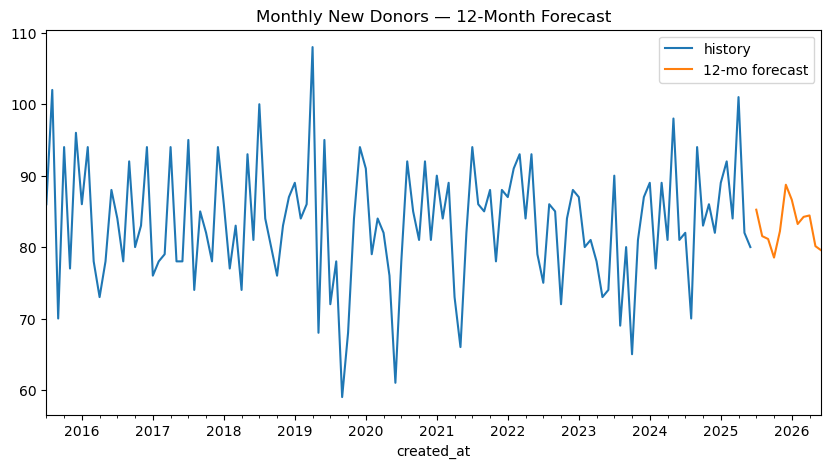

Saved forecast -> monthly_new_donors_forecast.csv


In [44]:
from math import sqrt

def rmse(a, f):
    return sqrt(np.mean((np.array(a)-np.array(f))**2))

forecast_path = 'monthly_new_donors_forecast.csv'

if ts is not None and len(ts) >= 24:
    train = ts.iloc[:-12]
    test  = ts.iloc[-12:]

    model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12, initialization_method='estimated')
    fit = model.fit(optimized=True)
    pred = fit.forecast(12)

    # Evaluation
    eval_rmse = rmse(test.values, pred.values)
    eval_mape = np.mean(np.abs((test.values - pred.values) / np.maximum(test.values, 1))) * 100.0
    print({'RMSE': round(eval_rmse,2), 'MAPE_%': round(eval_mape,2)})

    # Plot test vs forecast
    ax = train.plot(label='train')
    test.plot(ax=ax, label='test')
    pred.plot(ax=ax, label='forecast')
    ax.set_title('Holdout Test & Forecast (12 months)')
    ax.legend()
    plt.show()

    # Refit full and forecast next 12
    model_full = ExponentialSmoothing(ts, trend='add', seasonal='add', seasonal_periods=12, initialization_method='estimated')
    fit_full = model_full.fit(optimized=True)
    fcst = fit_full.forecast(12)

    # Plot full series with forecast
    ax = ts.plot(label='history')
    fcst.plot(ax=ax, label='12‑mo forecast')
    ax.set_title('Monthly New Donors — 12‑Month Forecast')
    ax.legend()
    plt.show()

    out = pd.DataFrame({'month': fcst.index.to_period('M').astype(str), 'forecast_new_donors': fcst.values})
    out.to_csv(forecast_path, index=False)
    print('Saved forecast ->', forecast_path)
else:
    print('Not enough data to forecast.')


## 8) Predicting Donor Availability (Yes/No)

We build two models:
- **Logistic Regression** (interpretable baseline)
- **Random Forest** (nonlinear baseline)

**Target:** `availability` (Yes/No) **Features:** `months_since_first_donation`, `number_of_donation`, `pints_donated`, `blood_group`, `city` (when present)


Logistic Regression Metrics
              precision    recall  f1-score   support

           0      0.487     0.444     0.464      1229
           1      0.504     0.547     0.525      1271

    accuracy                          0.496      2500
   macro avg      0.495     0.496     0.495      2500
weighted avg      0.496     0.496     0.495      2500

ROC-AUC: 0.497


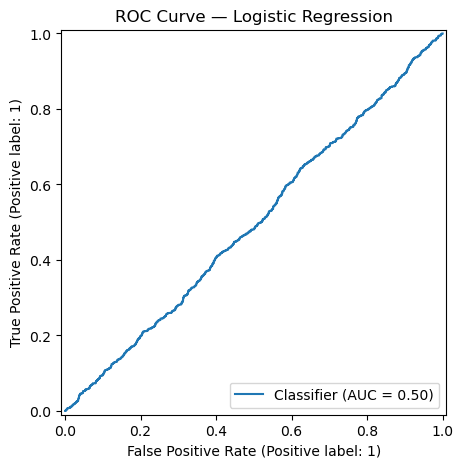

Random Forest Metrics
              precision    recall  f1-score   support

           0      0.480     0.473     0.476      1229
           1      0.498     0.505     0.501      1271

    accuracy                          0.489      2500
   macro avg      0.489     0.489     0.489      2500
weighted avg      0.489     0.489     0.489      2500

ROC-AUC: 0.489


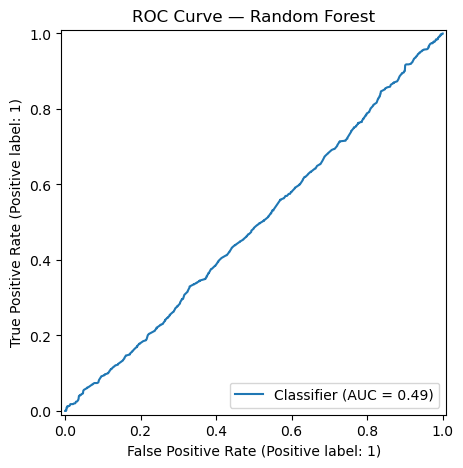

,feature,importance
257,city_Brisbane,0.017091
263,city_Sydney,0.016485
251,blood_group_AB-,0.016319
262,city_Perth,0.016217
261,city_Melbourne,0.016207
256,city_Adelaide,0.016129
258,city_Canberra,0.016110
259,city_Darwin,0.016078
250,blood_group_AB+,0.016066
260,city_Hobart,0.015934


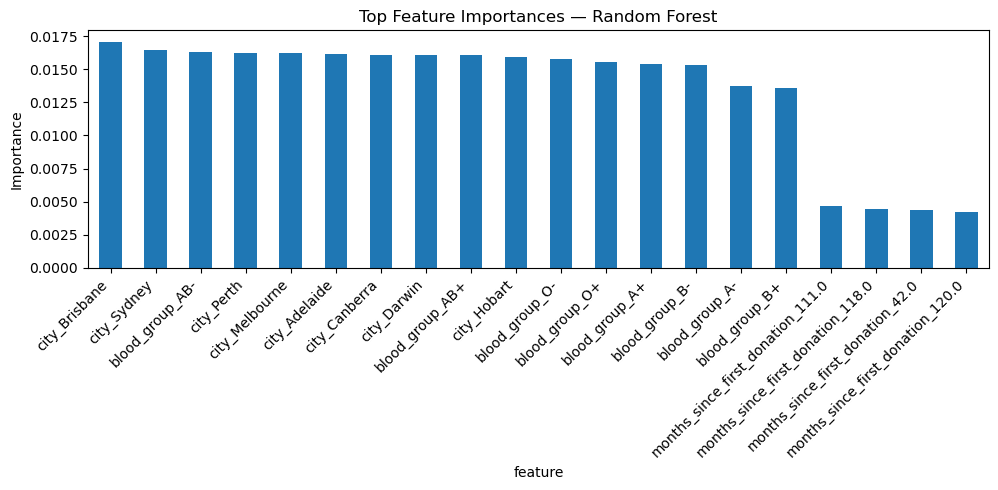

In [45]:
target_col = 'availability'
feature_cols = [c for c in ['months_since_first_donation','number_of_donation','pints_donated','blood_group','city'] if c in df.columns]

if target_col in df.columns and feature_cols:
    data = df[feature_cols + [target_col]].dropna().copy()
    # Map target to binary
    data[target_col] = data[target_col].map({'Yes':1, 'No':0}).astype(int)

    X = data[feature_cols]
    y = data[target_col]

    numeric_features = [c for c in feature_cols if str(X[c].dtype)[:3] in ['int','flo']]
    categorical_features = [c for c in feature_cols if c not in numeric_features]

    pre = ColumnTransformer([
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ], remainder='passthrough')

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED, stratify=y)

    # Logistic Regression
    logit = Pipeline(steps=[('pre', pre), ('clf', LogisticRegression(max_iter=1000))])
    logit.fit(X_train, y_train)
    preds_logit = logit.predict(X_test)
    proba_logit = logit.predict_proba(X_test)[:,1]

    print('Logistic Regression Metrics')
    print(classification_report(y_test, preds_logit, digits=3))
    print('ROC-AUC:', round(roc_auc_score(y_test, proba_logit), 3))

    RocCurveDisplay.from_predictions(y_test, proba_logit)
    plt.title('ROC Curve — Logistic Regression')
    plt.show()

    # Random Forest
    rf = Pipeline(steps=[('pre', pre), ('clf', RandomForestClassifier(n_estimators=300, random_state=RANDOM_SEED))])
    rf.fit(X_train, y_train)
    preds_rf = rf.predict(X_test)
    proba_rf = rf.predict_proba(X_test)[:,1]

    print('Random Forest Metrics')
    print(classification_report(y_test, preds_rf, digits=3))
    print('ROC-AUC:', round(roc_auc_score(y_test, proba_rf), 3))

    RocCurveDisplay.from_predictions(y_test, proba_rf)
    plt.title('ROC Curve — Random Forest')
    plt.show()

    # Feature importances (approximate, post-encoding)
    # Extract from RF pipeline
    rf_model = rf.named_steps['clf']
    # After ColumnTransformer, get feature names:
    oh_names = list(rf.named_steps['pre'].named_transformers_['onehot'].get_feature_names_out(categorical_features)) if categorical_features else []
    final_feature_names = oh_names + numeric_features
    importances = getattr(rf_model, 'feature_importances_', None)
    if importances is not None:
        imp_df = pd.DataFrame({'feature': final_feature_names, 'importance': importances}).sort_values('importance', ascending=False).head(20)
        display(imp_df)
        ax = imp_df.set_index('feature')['importance'].plot(kind='bar')
        ax.set_title('Top Feature Importances — Random Forest')
        ax.set_ylabel('Importance')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

else:
    print('Availability prediction skipped (missing target/feature columns). Found features:', feature_cols, 'Target present?', target_col in df.columns)


## 9) Save Artifacts

- `blood_donor_clean.csv` — PII dropped, engineered fields
- `monthly_new_donors_forecast.csv` — Next 12‑month forecast
- You can also export models using `joblib` if needed


All this done because of the using Copilot Ai